# Analysis of an optimal solution

In [3]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx
from ItalySetup import ItalySetup
from covidOCP import COVIDVaccinationOCP, COVIDParametersOCP
from main import pick_scenario
import seaborn as sns
import datetime
import pickle

nx = 9
states_names = ['S', 'E', 'P', 'I', 'A', 'Q', 'H', 'R', 'V']

nnodes = 107  # nodes

# Horizon for each problem
ndays = 90
when = 'future'

setup = ItalySetup(nnodes, ndays)
M = setup.nnodes
N = len(setup.model_days) - 1

with open(f'model_output/parameters_{nnodes}_{when}.pkl', 'rb') as inp:
    p = pickle.load(inp)

Loaded Italy Setup with 107 nodes.


In [5]:
md = pd.read_csv(f'{outdir}{file_prefix}-opt{nnodes}-r{mvr}-m{int(8e6)}.csv', index_col= 'date', parse_dates=True)

In [310]:

G = networkx.Graph()
G.position = {}
G.population = {}
G.comp = {}
G.epi = {}
setup.shp['vacc'] = np.nan
setup.shp['Rend'] = np.nan
for i, node in enumerate(setup.ind2name):
    G.add_node(node)
    G.position[node] = (setup.pos_node[i,0], setup.pos_node[i,1])
    G.population[node] = setup.pop_node[i]
    #G.comp[node] = (ocp.ic['S'][i], ocp.ic['I'][i],ocp.ic['R'][i])
    G.epi[node] = {'vacc': md[(md['place']==node) & (md['comp']=='vacc')]['value'].sum(),
               'Rend':  md[(md['place']==node) & (md['comp']=='R')]['value'][-1]}
    setup.shp.loc[i, 'vacc'] = md[(md['place']==node) & (md['comp']=='vacc')]['value'].sum()
    setup.shp.loc[i, 'Rend'] = md[(md['place']==node) & (md['comp']=='R')]['value'][-1]
        
    setup.shp.loc[i, 'population'] =  setup.pop_node[i] # overwrite 
    for j, connection in enumerate(p.mobmat_pr[i]):
        if connection != 0:
            G.add_edge(node, setup.ind2name[j], weight=connection)
G.number_of_edges()

366

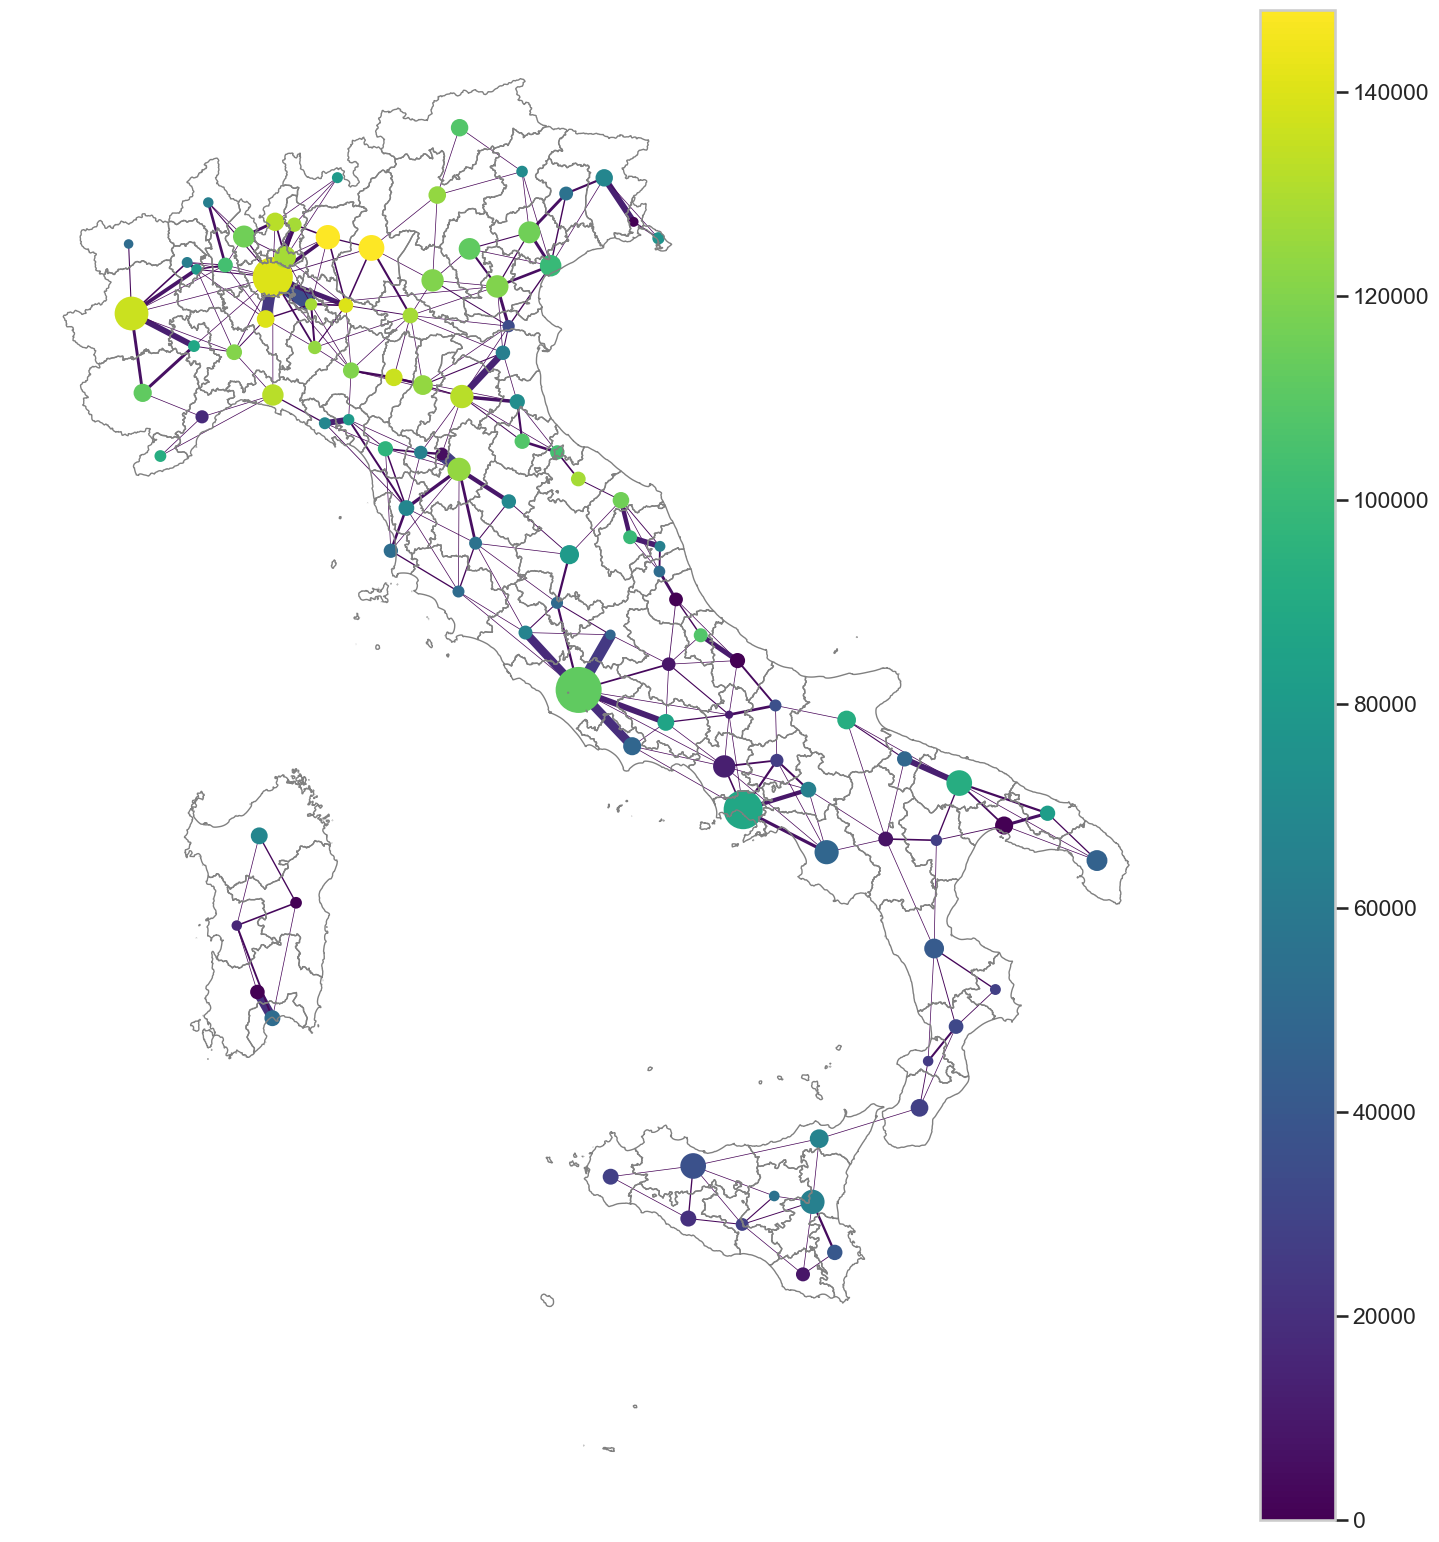

In [323]:
fig, ax = plt.subplots(1,1,figsize=(20, 20))


networkx.draw(G, 
         G.position, 
         node_size=1000/max(setup.pop_node) * np.array([G.population[v] for v in G]),
          #node_color=[float(G.degree(v)) for v in G],
          #node_color=[G.population[v] for v in G],
          #node_color=[G.epi[v]['vacc']/G.population[v] for v in G],
          node_color= [G.epi[v]['vacc'] for v in G],
          width = 50* np.array([max(a['weight'],0.01) for u,v,a in G.edges(data=True)]),
          edge_color= 10 * np.array([a['weight'] for u,v,a in G.edges(data=True)]),
          edge_cmap = mpl.cm.viridis,
        cmap = mpl.cm.viridis,
          ax = ax,
         with_labels=False
       )

#     # scale the axes equally
#plt.xlim(min(s.pos_node[:,0]) - 100000, max(s.pos_node[:,0])+ 100000)
#plt.ylim(min(s.pos_node[:,1]) - 100000, max(s.pos_node[:,1])+ 100000)

#s.shp.plot(ax = ax, column='' cmap='OrRd', facecolor="none", edgecolor="black")

setup.shp.boundary.plot(ax = ax,  edgecolor="grey", linewidth = 1)


cmap = mpl.cm.viridis#sns.cm.rocket
vmin = min([G.epi[v]['vacc'] for v in G])
vmax = max([G.epi[v]['vacc'] for v in G])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
#sm._A = []
plt.colorbar(sm)

plt.draw()

<AxesSubplot:>

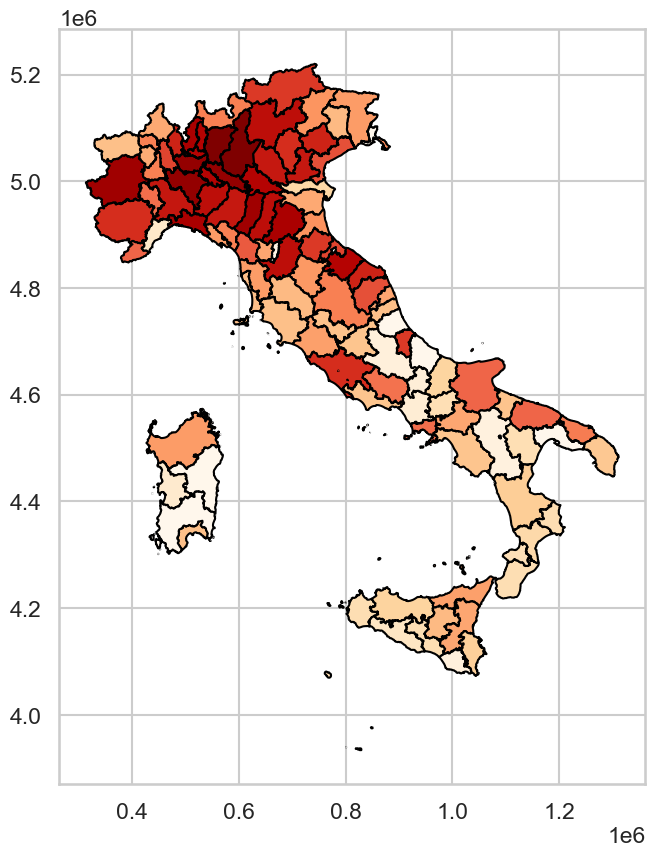

In [313]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))
setup.shp.plot(ax = ax, column='vacc', cmap='OrRd',  edgecolor="black") #facecolor="none",

(0.0, 0.08083146325064906)

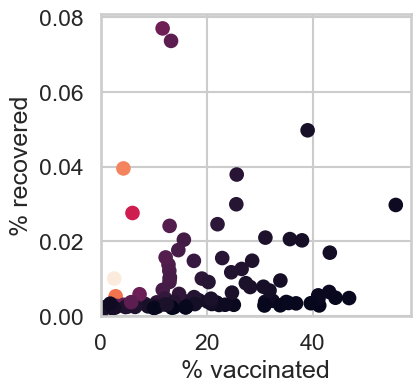

In [328]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4, 4))
plt.scatter(setup.shp['vacc']/setup.shp['population']*100, setup.shp['Rend']/setup.shp['population']*100, c= setup.shp['population'])
ax.set_xlabel("% vaccinated")
ax.set_ylabel("% recovered");
ax.set_xlim(0)
ax.set_ylim(0)

/Users/chadi/opt/miniconda3/envs/ocp-covid/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


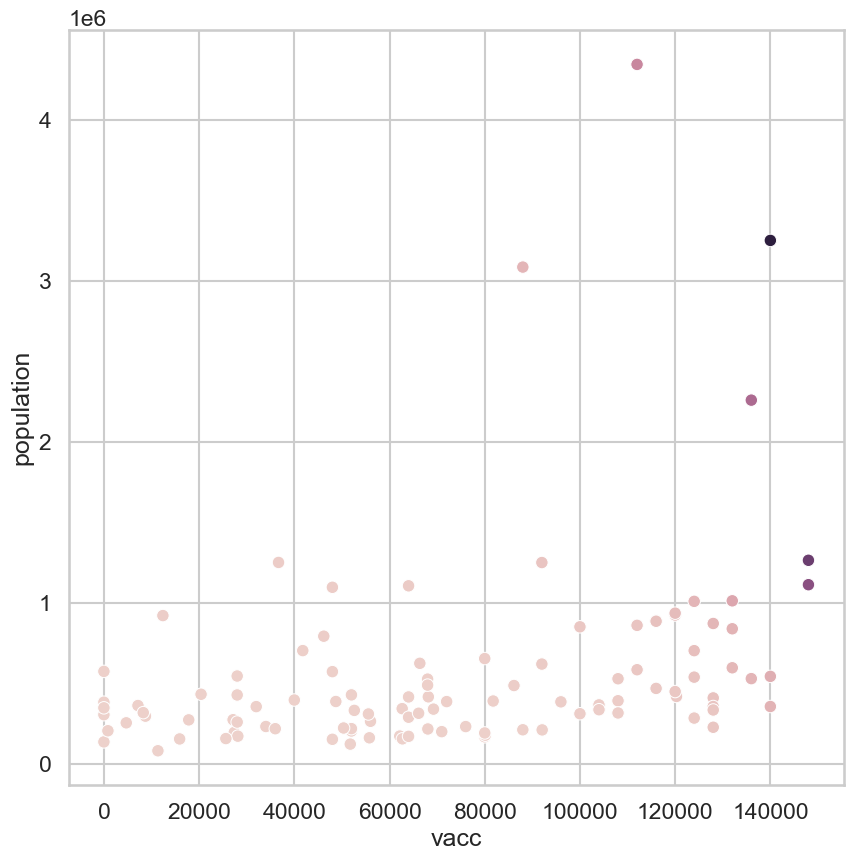

In [334]:
ax = sns.scatterplot(setup.shp['vacc'], setup.shp['population'], hue=setup.shp['Rend'])
ax.get_legend().remove();

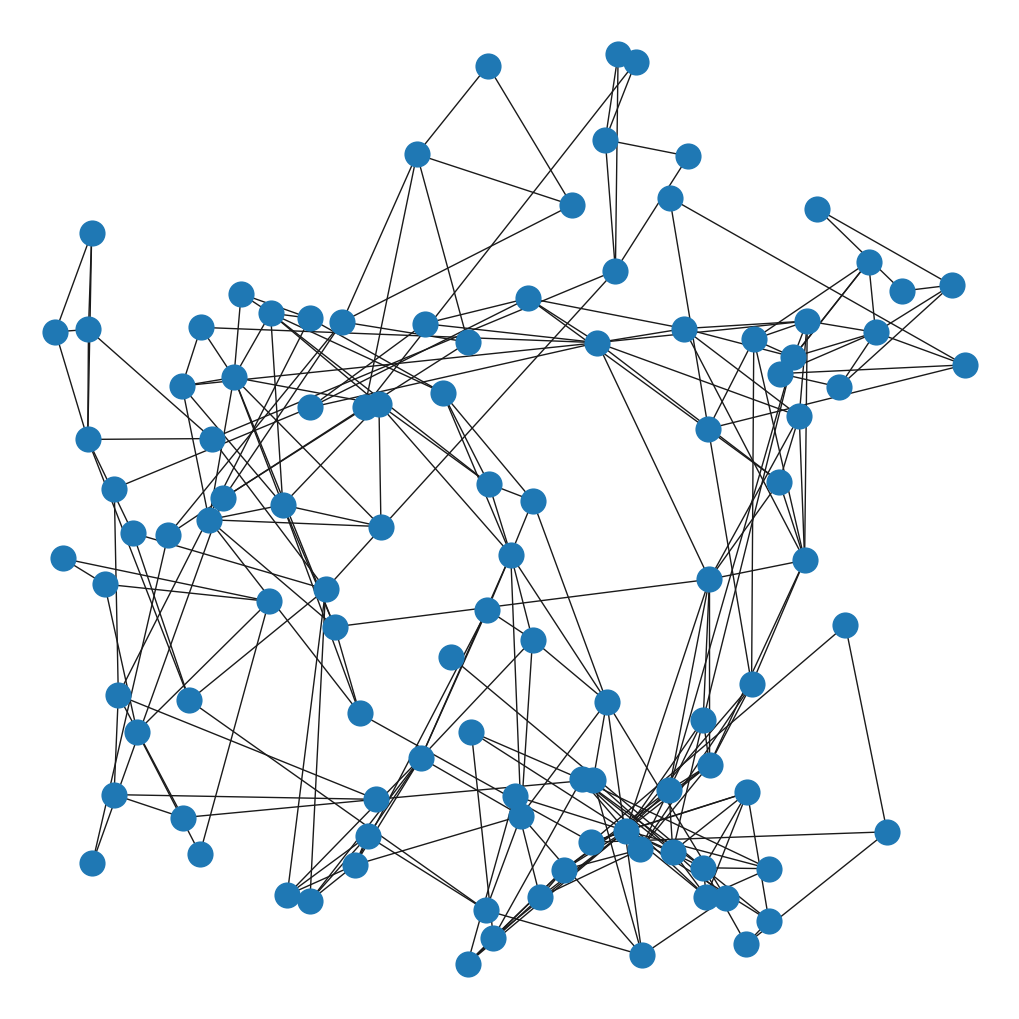

In [316]:
grph = networkx.from_numpy_matrix(p.mobmat_pr)
networkx.draw(grph)